### Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)

### Connect to the Hopsworks Feature Store

In [ ]:
# Remember to comment out when pushing to git
if not os.environ["HOPSWORKS_API_KEY"]:
    with open('../data/keys/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(project="ML_Project_Electricity", api_key_value=os.environ["HOPSWORKS_API_KEY"])
fs = project.get_feature_store() 

2025-01-09 14:10:36,415 INFO: Initializing external client
2025-01-09 14:10:36,417 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-09 14:10:36,417 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-09 14:10:37,599 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207495


### Get the feature views


In [5]:
feature_view_se3 = fs.get_feature_view(
    name='se3_price_fv',
    version=1,
)

feature_view_se4 = fs.get_feature_view(
    name='se4_price_fv',
    version=1,
)

### Download the model from hopsworks

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="electricity_price_xgboost_model_with_lagged",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.0643677E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'int', 'float',
                            'int', 'int', 'int', 'float', 'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Get Weather Forecast Features from the feature groups



In [8]:
sthlm_weather_fg = fs.get_feature_group(
    name='stockholm_weather',
    version=1,
)

malmo_weather_fg = fs.get_feature_group(
    name='malmo_weather',
    version=1,
)

sthlm_weather_data = sthlm_weather_fg.filter(sthlm_weather_fg.date >= today).read()
malmo_weather_data = malmo_weather_fg.filter(malmo_weather_fg.date >= today).read()

# Ensure the 'date' column is in datetime format
sthlm_weather_data['date'] = pd.to_datetime(sthlm_weather_data['date'])
malmo_weather_data['date'] = pd.to_datetime(malmo_weather_data['date'])

# Sort the weather data by the 'date' column
# sthlm_weather_data.sort_values(by='date', inplace=True)
# malmo_weather_data.sort_values(by='date', inplace=True)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.53s) 


In [9]:
# skip the feature view and simply get the last available rolling mean from the price feature group
se3_price_fg = fs.get_feature_group(
    name='se3_electricity_prices',
    version=1,
)

se4_price_fg = fs.get_feature_group(
    name='se4_electricity_prices',
    version=1,
)

se3_price_data = se3_price_fg.read()
se4_price_data = se4_price_fg.read()

# Ensure the 'time' column is in datetime format
se3_price_data['time'] = pd.to_datetime(se3_price_data['time'])
se4_price_data['time'] = pd.to_datetime(se4_price_data['time'])

# Sort the price data by the 'time' column
se3_price_data.sort_values(by='time', inplace=True)
se4_price_data.sort_values(by='time', inplace=True)

se3_price_data.tail()

# get the last available rolling mean from the price feature group
se3_last_rolling_mean = se3_price_data['spot_price_rolling'].iloc[-1]
se4_last_rolling_mean = se4_price_data['spot_price_rolling'].iloc[-1]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


In [17]:
se3_price_data.tail()

,time,pricearea,spotpriceeur,spot_price_rolling,spot_price_rolling_3h
17545,2025-01-09 18:00:00+00:00,SE3,127.59,34.408809,131.490000
17547,2025-01-09 19:00:00+00:00,SE3,119.99,35.610774,122.523333
17563,2025-01-09 20:00:00+00:00,SE3,102.52,36.617440,108.343333
17561,2025-01-09 21:00:00+00:00,SE3,97.85,37.595179,99.406667
17556,2025-01-09 22:00:00+00:00,SE3,68.53,38.242679,78.303333


In [11]:
# Add the last available rolling mean to the weather data

# Keep using the same last week average price for the next days predictions
sthlm_weather_data['spot_price_rolling'] = se3_last_rolling_mean
malmo_weather_data['spot_price_rolling'] = se4_last_rolling_mean

# Add the last available "spot_price_rolling_3h" data from price data to the weather data
# Missing (future) values will be filled with NaN, and will be prediced iteratively
sthlm_weather_data = pd.merge(sthlm_weather_data, se3_price_data[['time', 'spot_price_rolling_3h']], on='time', how='left')
malmo_weather_data = pd.merge(malmo_weather_data, se4_price_data[['time', 'spot_price_rolling_3h']], on='time', how='left')

# sort the weather data by the 'time' column
sthlm_weather_data.sort_values(by='time', inplace=True)
malmo_weather_data.sort_values(by='time', inplace=True)

sthlm_weather_data.head()


,date,time,temperature,precipitation,cloud_cover,wind_speed_10m,weekday,month,hour,sunshine_duration,spot_price_rolling,spot_price_rolling_3h
22,2025-01-10 00:00:00+00:00,2025-01-10 00:00:00+00:00,-1.1825,0.0,92,3.24,4,1,0,14793.331055,38.242679,NaN
20,2025-01-10 00:00:00+00:00,2025-01-10 01:00:00+00:00,-1.0825,0.0,92,5.04,4,1,1,14793.331055,38.242679,NaN
12,2025-01-10 00:00:00+00:00,2025-01-10 02:00:00+00:00,-1.3325,0.0,92,7.92,4,1,2,14793.331055,38.242679,NaN
5,2025-01-10 00:00:00+00:00,2025-01-10 03:00:00+00:00,-1.2325,0.0,98,9.00,4,1,3,14793.331055,38.242679,NaN
23,2025-01-10 00:00:00+00:00,2025-01-10 04:00:00+00:00,-1.4825,0.0,100,9.72,4,1,4,14793.331055,38.242679,NaN


In [12]:
# Combine the weather data into one dataframe with a feature for region, 0 for Stockholm and 1 for Malmo

# Add a column for the region
sthlm_weather_data['region'] = 0
malmo_weather_data['region'] = 1

# Combine the weather data
weather_data = pd.concat([sthlm_weather_data, malmo_weather_data], axis=0)

In [ ]:
weather_data.head()

,date,time,temperature,precipitation,cloud_cover,wind_speed_10m,weekday,month,hour,sunshine_duration,spot_price_rolling,spot_price_rolling_3h,region
22,2025-01-10 00:00:00+00:00,2025-01-10 00:00:00+00:00,-1.1825,0.0,92,3.24,4,1,0,14793.331055,38.242679,NaN,0
20,2025-01-10 00:00:00+00:00,2025-01-10 01:00:00+00:00,-1.0825,0.0,92,5.04,4,1,1,14793.331055,38.242679,NaN,0
12,2025-01-10 00:00:00+00:00,2025-01-10 02:00:00+00:00,-1.3325,0.0,92,7.92,4,1,2,14793.331055,38.242679,NaN,0
5,2025-01-10 00:00:00+00:00,2025-01-10 03:00:00+00:00,-1.2325,0.0,98,9.00,4,1,3,14793.331055,38.242679,NaN,0
23,2025-01-10 00:00:00+00:00,2025-01-10 04:00:00+00:00,-1.4825,0.0,100,9.72,4,1,4,14793.331055,38.242679,NaN,0


In [14]:
features_se3 = sthlm_weather_data.drop(columns=['date', 'time'])
features_se4 = malmo_weather_data.drop(columns=['date', 'time'])

# Rearrange the columns to match the expected feature names
expected_feature_names = ['spot_price_rolling', 'spot_price_rolling_3h', 'temperature', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'weekday', 'month', 'hour', 'sunshine_duration', 'region']
features_se3 = features_se3[expected_feature_names]
features_se4 = features_se4[expected_feature_names]


# Create a DataFrame to store the predictions
predictions_df_se3 = pd.DataFrame({
    'time': sthlm_weather_data['time'],
    'predicted_price': None,
    'region': 0
})

predictions_df_se4 = pd.DataFrame({
    'time': malmo_weather_data['time'],
    'predicted_price': None,
    'region': 1
})

# Predict one row at a time iteratively
for i, row in features_se3.iterrows():
    # Prepare the input data for prediction
    input_data = pd.DataFrame({
            'spot_price_rolling': [row['spot_price_rolling']],
            'spot_price_rolling_3h': [row['spot_price_rolling_3h']],
            'temperature': [row['temperature']],
            'precipitation': [row['precipitation']],
            'cloud_cover': [row['cloud_cover']],
            'wind_speed_10m': [row['wind_speed_10m']],
            'weekday': [row['weekday']],
            'month': [row['month']],
            'hour': [row['hour']],
            'sunshine_duration': [ row['sunshine_duration']],
            'region': [row['region']]
        })
    # If the spot_price_rolling_3h is missing, calculate it using the last available rolling mean and the last available predicted price
    if pd.isnull(row['spot_price_rolling_3h']):
        new_rolling_mean = (2 * previous_rolling_mean + last_predicted_price) / 3
        input_data['spot_price_rolling_3h'] = new_rolling_mean
        # Update the rolling mean
        previous_rolling_mean = new_rolling_mean
    else:
        previous_rolling_mean = row['spot_price_rolling_3h']

    # Predict the price
    prediction = retrieved_xgboost_model.predict(input_data)[0]
    last_predicted_price = prediction

    # Store the prediction
    predictions_df_se3.at[i, 'predicted_price'] = prediction

# predictions_df_se3.tail()

# Do the same for the Malmo region
for i, row in features_se4.iterrows():
    # Prepare the input data for prediction
    input_data = pd.DataFrame({
            'spot_price_rolling': [row['spot_price_rolling']],
            'spot_price_rolling_3h': [row['spot_price_rolling_3h']],
            'temperature': [row['temperature']],
            'precipitation': [row['precipitation']],
            'cloud_cover': [row['cloud_cover']],
            'wind_speed_10m': [row['wind_speed_10m']],
            'weekday': [row['weekday']],
            'month': [row['month']],
            'hour': [row['hour']],
            'sunshine_duration': [ row['sunshine_duration']],
            'region': [row['region']]
        })
    # If the spot_price_rolling_3h is missing, calculate it using the last available rolling mean and the last available predicted price
    if pd.isnull(row['spot_price_rolling_3h']):
        new_rolling_mean = (2 * previous_rolling_mean + last_predicted_price) / 3
        input_data['spot_price_rolling_3h'] = new_rolling_mean
        # Update the rolling mean
        previous_rolling_mean = new_rolling_mean
    else:
        previous_rolling_mean = row['spot_price_rolling_3h']
    
    # Predict the price
    prediction = retrieved_xgboost_model.predict(input_data)[0]
    last_predicted_price = prediction

    # Store the prediction
    predictions_df_se4.at[i, 'predicted_price'] = prediction

# predictions_df_se4.tail()



NameError: name 'previous_rolling_mean' is not defined

### Plot the predictions and save them in the docs/plots folder so they can be displayed using Github Pages

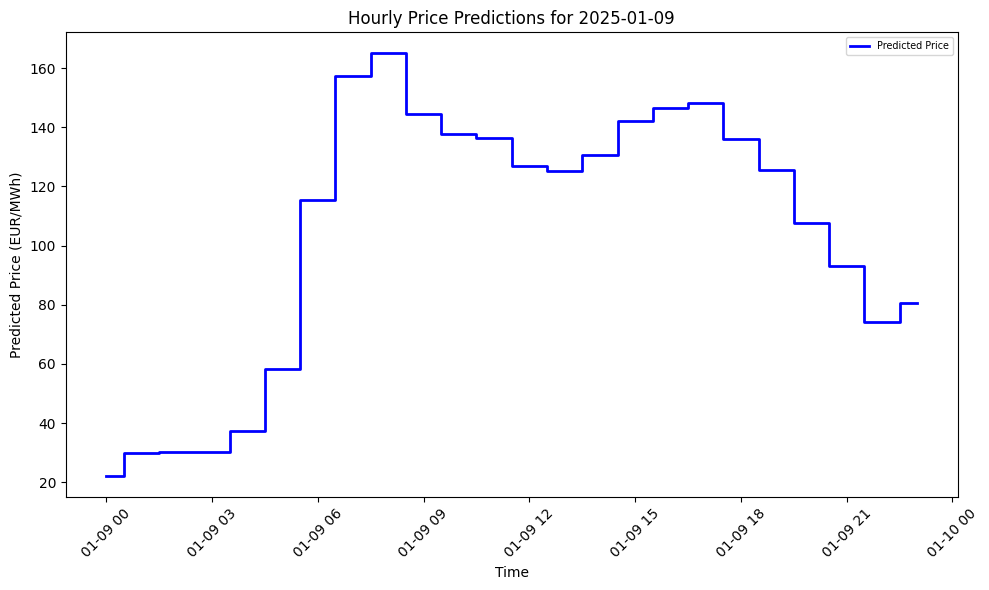

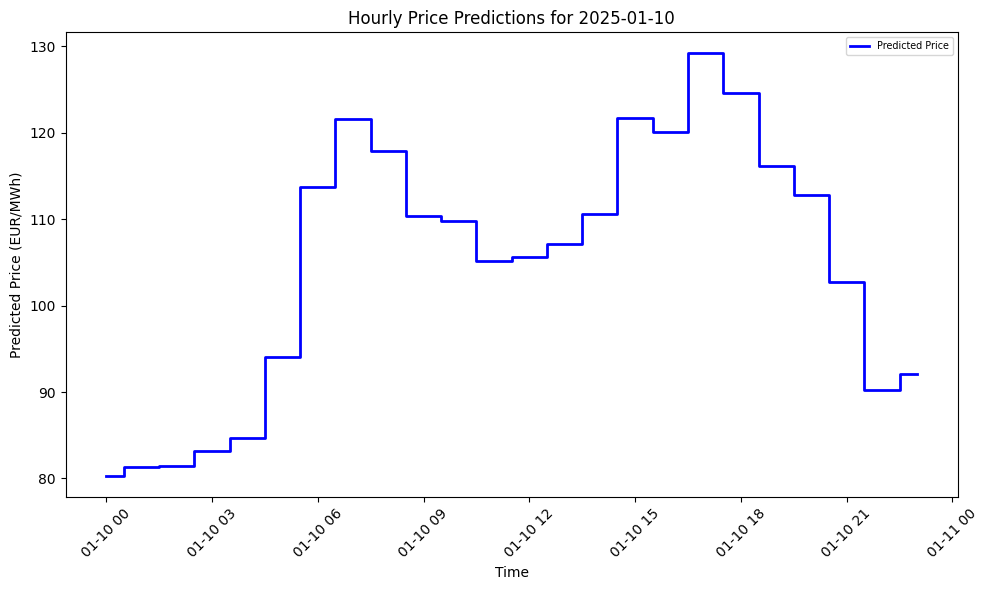

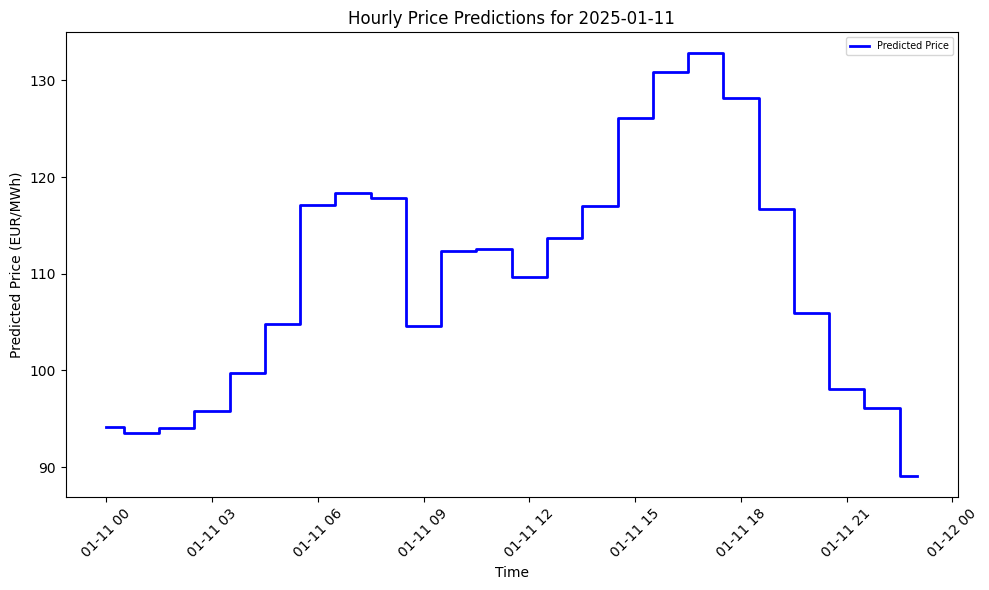

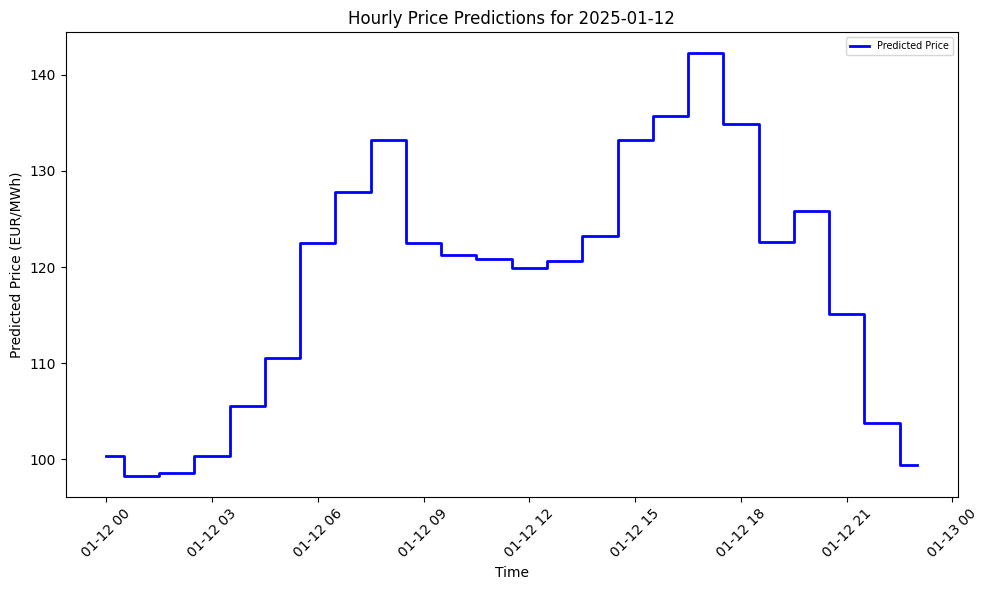

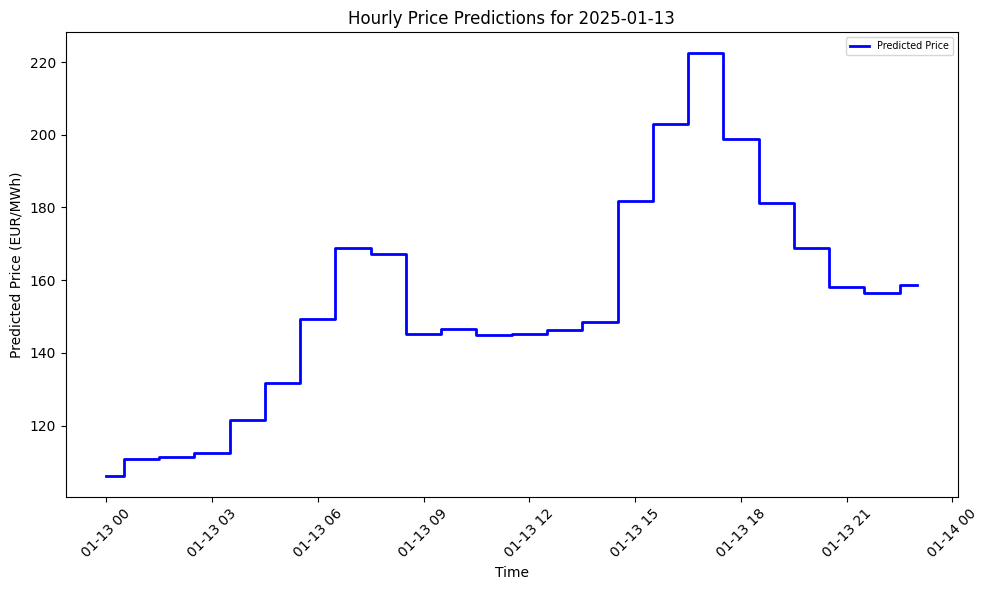

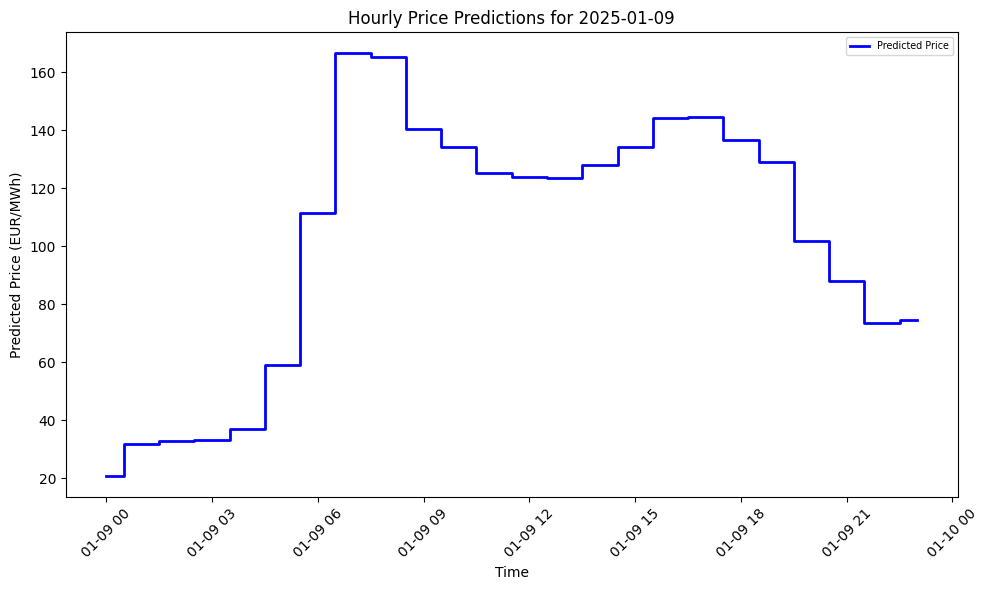

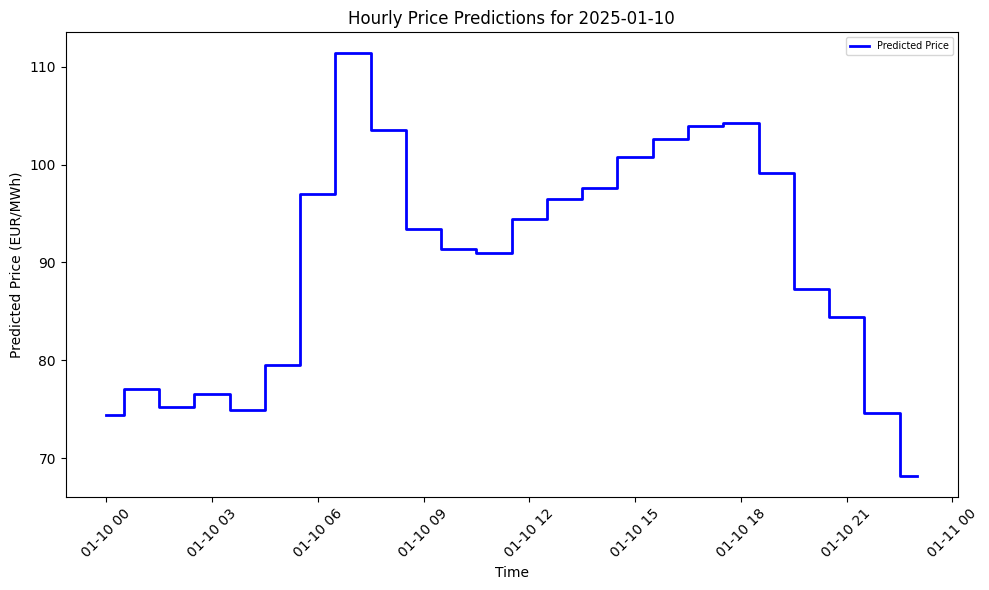

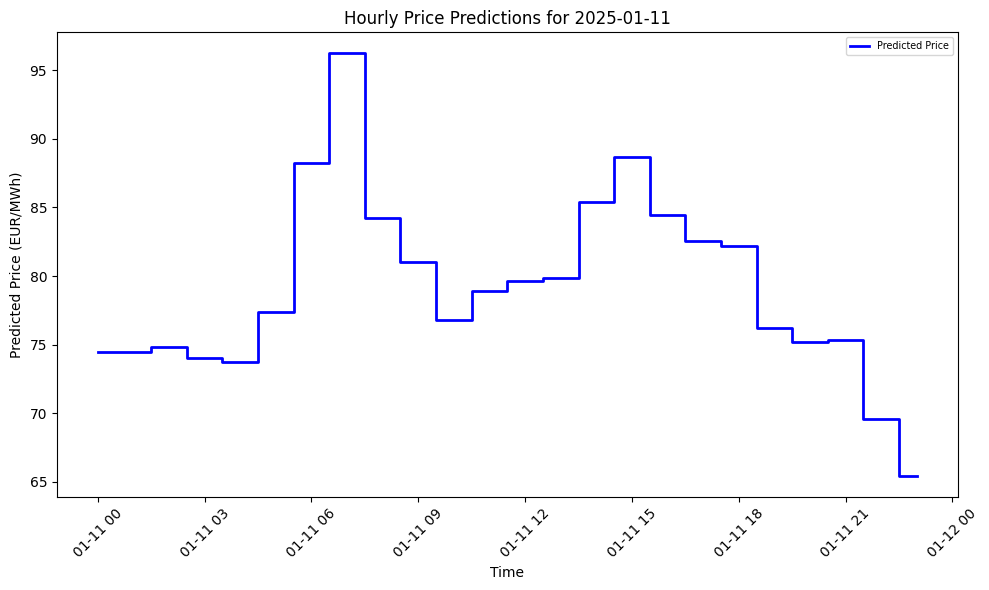

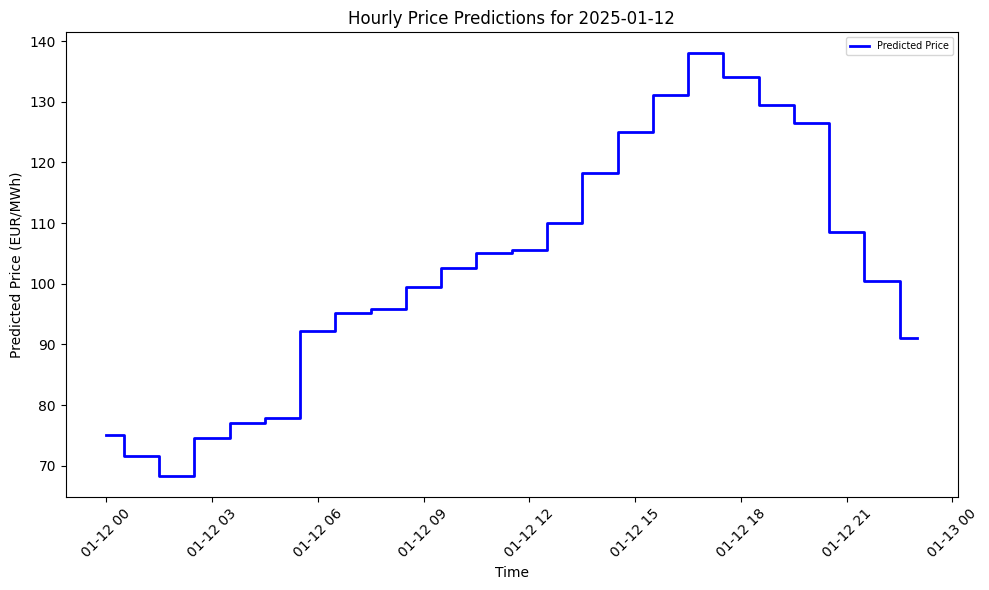

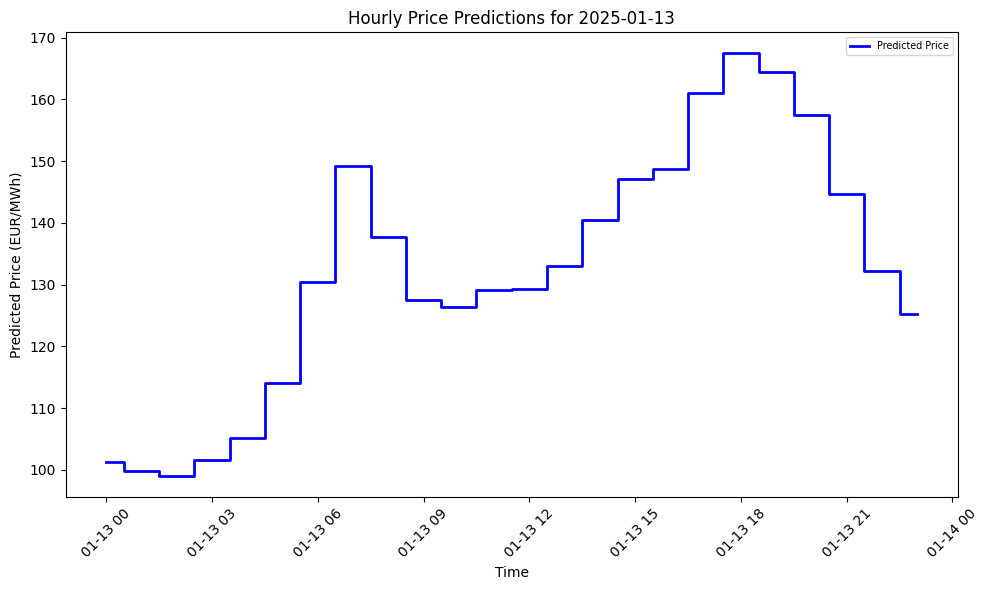

In [ ]:
# For each date in the predictions DataFrame, create a separate plot and save it in the plots folder

for i, date in enumerate(predictions_df_se3['time'].dt.date.unique()):
    file_path = f"../docs/plots/hourly_price_predictions_se3_{i}.png"
    plt = util.plot_hourly_price_predictions(predictions_df_se3, str(date), file_path)
    plt.show()

for i, date in enumerate(predictions_df_se4['time'].dt.date.unique()):
    file_path = f"../docs/plots/hourly_price_predictions_se4_{i}.png"
    plt = util.plot_hourly_price_predictions(predictions_df_se4, str(date), file_path)
    plt.show()
